In [1]:
!pip install blocksnet==0.0.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 669.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.6/355.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
from osmnx.features import InsufficientResponseError
from tqdm import tqdm
from shapely import Polygon,MultiPolygon
import shapely
import contextily as cx

In [2]:
def fetch_territory(territory_name):

    territory = ox.geocode_to_gdf(territory_name)
    territory = territory.set_crs(4326)
    territory = territory["geometry"].reset_index(drop=True)
    territory = gpd.GeoDataFrame(territory.make_valid(),columns=['geometry'])

    return territory


def fetch_buildings(territory, express_mode=True):

    if type(territory) in [gpd.GeoDataFrame,gpd.GeoSeries]:
        territory = territory.unary_union

    buildings = ox.features_from_polygon(territory, tags={"building": True})
    buildings = buildings.loc[buildings["geometry"].type == "Polygon"]

    if not express_mode:
        buildings_ = ox.features_from_polygon(territory, tags={"building": "yes"})
        buildings_ = buildings_.loc[buildings_["geometry"].type == "Polygon"]["geometry"]
        buildings = gpd.GeoSeries(pd.concat([buildings, buildings_], ignore_index=True)).drop_duplicates()

    try:
        buildings = buildings[["geometry", "building:levels"]].reset_index(drop=True).rename(columns={"building:levels": "levels"})
    except:
        buildings = buildings["geometry"].reset_index(drop=True)

    buildings = gpd.GeoDataFrame(buildings)

    return buildings


def fetch_roads(territory):
    tags = {
        "highway": ["construction","crossing","living_street","motorway","motorway_link","motorway_junction","pedestrian","primary","primary_link","raceway","residential","road","secondary","secondary_link","services","tertiary","tertiary_link","track","trunk","trunk_link","turning_circle","turning_loop","unclassified",],
        "service": ["living_street", "emergency_access"]
    }

    if type(territory) in [gpd.GeoDataFrame,gpd.GeoSeries]:
        territory = territory.unary_union

    try:
        roads = ox.features_from_polygon(territory, tags)
    except:
        print('too many roads...')
        roads = fetch_long_query(territory,tags)

    roads = roads.loc[roads.geom_type.isin(['LineString','MultiLineString'])]
    roads = roads.reset_index(drop=True)["geometry"]

    roads = gpd.GeoDataFrame(roads)

    return roads


def fetch_water(territory):

    if type(territory) in [gpd.GeoDataFrame,gpd.GeoSeries]:
        territory = territory.unary_union

    water = ox.features_from_polygon(
        territory, {'riverbank':True,
                    'reservoir':True,
                    'basin':True,
                    'dock':True,
                    'canal':True,
                    'pond':True,
                    'natural':['water','bay'],
                    'waterway':['river','canal','ditch'],
                    'landuse':'basin'})
    water = water.loc[water.geom_type.isin(
        ['Polygon','MultiPolygon','LineString','MultiLineString'])]

    water = water.reset_index(drop=True)["geometry"].drop_duplicates()
    water = gpd.GeoDataFrame(water)

    return water


def fetch_railways(territory):

    if type(territory) in [gpd.GeoDataFrame,gpd.GeoSeries]:
        territory = territory.unary_union

    railway = ox.features_from_polygon(
        territory, {"railway": "rail"}).reset_index(drop=True)

    try:
        railway = railway.query('service not in ["crossover","siding","yard"]')
    except:
        pass

    railway = railway["geometry"]
    railway  = gpd.GeoDataFrame(railway)

    return railway


def create_grid(gdf=None, n_cells=5, crs=4326):

    if type(gdf) in [gpd.GeoDataFrame,gpd.GeoSeries]:
        xmin, ymin, xmax, ymax= gdf.total_bounds
    elif type(gdf) in [Polygon,MultiPolygon]:
        xmin, ymin, xmax, ymax= gdf.bounds

    cell_size = (xmax-xmin)/n_cells
    grid_cells = []

    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            grid_cells.append(poly)

    cells = gpd.GeoDataFrame(grid_cells, columns=['geometry'],crs=crs)

    if type(gdf) in [gpd.GeoDataFrame,gpd.GeoSeries]:
        cells = gdf.overlay(cells,keep_geom_type=True)
    elif type(gdf) in [Polygon,MultiPolygon]:
        cells = gdf.intersection(cells)

    cells = cells[~cells.is_empty].set_crs(crs)
    cells = cells[np.logical_or(
        cells.type=='Polygon',cells.type=='MultiPolygon')]

    return cells



def fetch_long_query(territory, tags, subdivision=3,verbose=True):

    if type(territory) in [gpd.GeoDataFrame,gpd.GeoSeries]:
        territory = territory.unary_union

    cells = create_grid(territory,n_cells=subdivision)
    res_list = []

    for poly in tqdm(cells['geometry'],leave=False,disable=not verbose):
        try:
            objects_in_cell = ox.features_from_polygon(poly, tags)
        except InsufficientResponseError:
            continue
        except:
            objects_in_cell = fetch_long_query(poly,tags,subdivision)

        if len(objects_in_cell) > 0: res_list.append(objects_in_cell)

    res = pd.concat(res_list) if res_list else gpd.GeoDataFrame()

    return res

In [8]:
territory_name = 'Смоленск'
data_dir = '/content'

<Axes: >

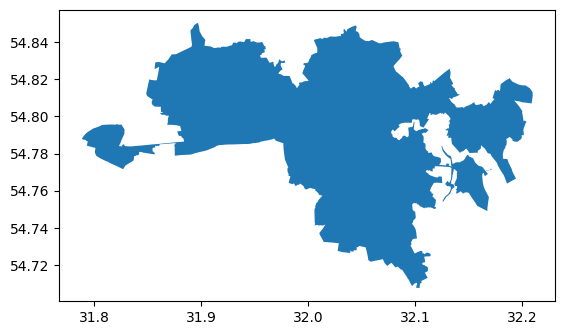

In [9]:
territory = fetch_territory(territory_name)
territory.plot()

<Axes: >

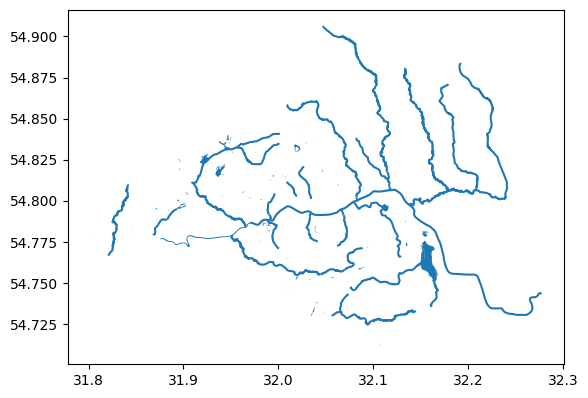

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [10]:
water = fetch_water(territory)
water.plot()

<Axes: >

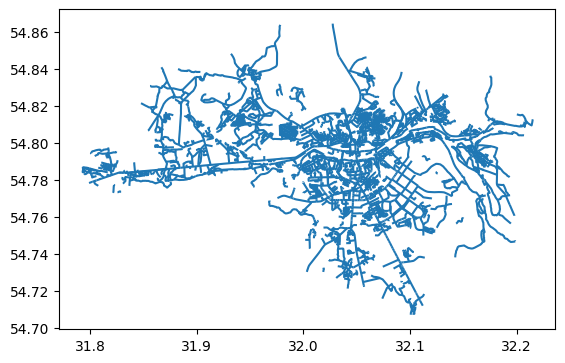

In [11]:
roads = fetch_roads(territory)
roads.plot()

<Axes: >

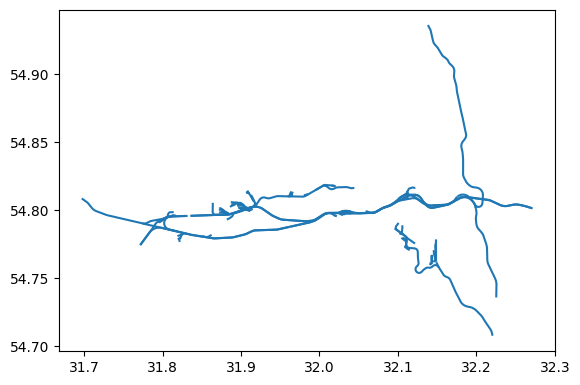

In [12]:
railways = fetch_railways(territory)
railways.plot()

In [13]:
territory.to_file(f'{data_dir}/territory.geojson')
water.to_file(f'{data_dir}/water.geojson')
roads.to_file(f'{data_dir}/roads.geojson')
railways.to_file(f'{data_dir}/railways.geojson')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [14]:
territory = gpd.read_file(f'{data_dir}/territory.geojson')
water = gpd.read_file(f'{data_dir}/water.geojson')
roads = gpd.read_file(f'{data_dir}/roads.geojson')
railways = gpd.read_file(f'{data_dir}/railways.geojson')

In [21]:
local_crs = territory.estimate_utm_crs()
territory = territory.to_crs(local_crs)
water = water.to_crs(local_crs)
roads = roads.to_crs(local_crs)
railways = railways.to_crs(local_crs)

In [26]:
ec = 'r'

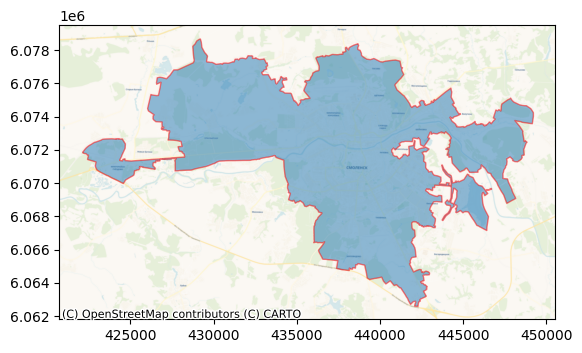

In [27]:
ax = territory.plot(alpha=0.5, edgecolor=ec)
cx.add_basemap(ax, crs=territory.crs, source=cx.providers.CartoDB.Voyager)

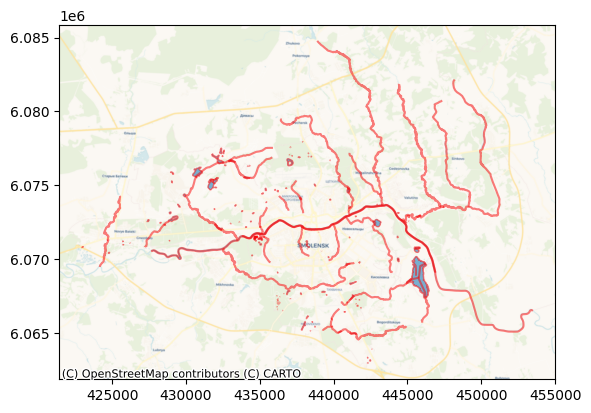

In [28]:
ax = water.plot(alpha=0.5, edgecolor=ec)
cx.add_basemap(ax, crs=water.crs, source=cx.providers.CartoDB.Voyager)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


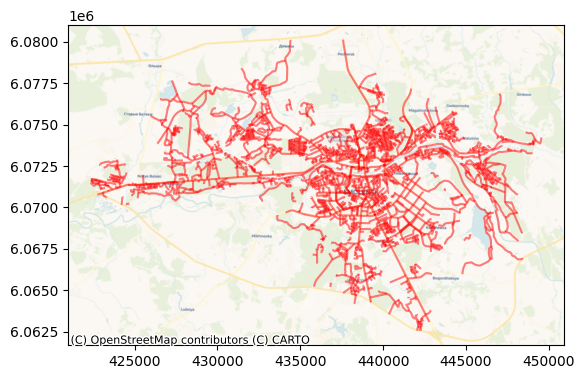

In [29]:
ax = roads.plot(alpha=0.5, edgecolor=ec)
cx.add_basemap(ax, crs=roads.crs, source=cx.providers.CartoDB.Voyager)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


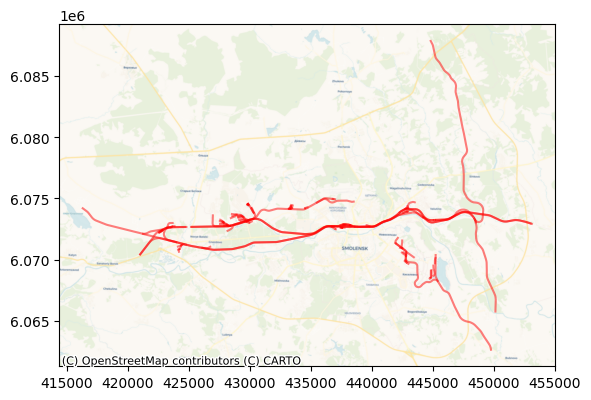

In [30]:
ax = railways.plot(alpha=0.5, edgecolor=ec)
cx.add_basemap(ax, crs=railways.crs, source=cx.providers.CartoDB.Voyager)

In [31]:
from blocksnet import BlocksGenerator

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [32]:
blocks_generator = BlocksGenerator(territory=territory, water=water, roads=roads, railways=railways)

In [33]:
blocks_unfiltered = blocks_generator.generate_blocks(); blocks_unfiltered

GENERATING BLOCKS
Setting up enclosures...
Filling holes...
Dropping overlapping blocks...
Calculating blocks area...
Blocks generated.



<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,geometry
0,"POLYGON ((440296.060 6067988.806, 440287.246 6..."
1,"POLYGON ((440291.398 6068075.217, 440285.464 6..."
2,"POLYGON ((439499.659 6069556.673, 439505.909 6..."
3,"POLYGON ((439531.255 6069490.644, 439505.909 6..."
4,"POLYGON ((437171.181 6069678.351, 437180.223 6..."
...,...
1230,"POLYGON ((449088.745 6073610.735, 449092.241 6..."
1231,"POLYGON ((448426.006 6073296.401, 448455.273 6..."
1232,"POLYGON ((449091.905 6073680.316, 449091.587 6..."
1233,"POLYGON ((423617.976 6072685.638, 423626.679 6..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


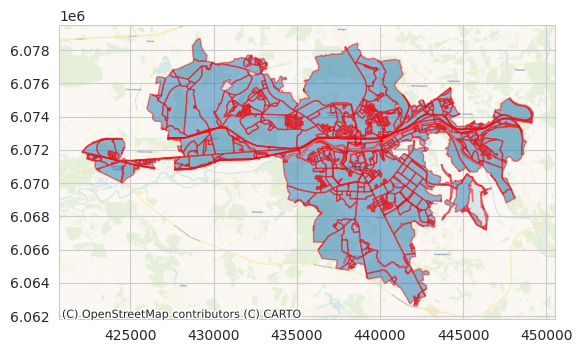

In [34]:
ax = blocks_unfiltered.plot(alpha=0.5, edgecolor=ec)
cx.add_basemap(ax, crs=blocks_unfiltered.crs, source=cx.providers.CartoDB.Voyager)

In [35]:
blocks_unfiltered.explore()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [36]:
blocks_filtered = blocks_generator.generate_blocks(min_block_width=30)
blocks_filtered

GENERATING BLOCKS
Setting up enclosures...
Filling holes...
Dropping overlapping blocks...
Filtering bottlenecks and small blocks...
Calculating blocks area...
Blocks generated.



,geometry
0,"POLYGON ((440287.246 6068016.822, 440285.356 6..."
1,"POLYGON ((439506.057 6069543.999, 439499.991 6..."
2,"POLYGON ((437179.981 6069666.368, 437180.223 6..."
3,"POLYGON ((437235.605 6069605.688, 437180.223 6..."
4,"POLYGON ((438533.523 6072769.365, 438532.714 6..."
...,...
948,"POLYGON ((441478.868 6072584.652, 441639.422 6..."
949,"POLYGON ((443153.133 6074388.250, 443117.913 6..."
950,"POLYGON ((422931.207 6071685.037, 422683.624 6..."
951,"POLYGON ((448488.425 6073205.044, 448526.857 6..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


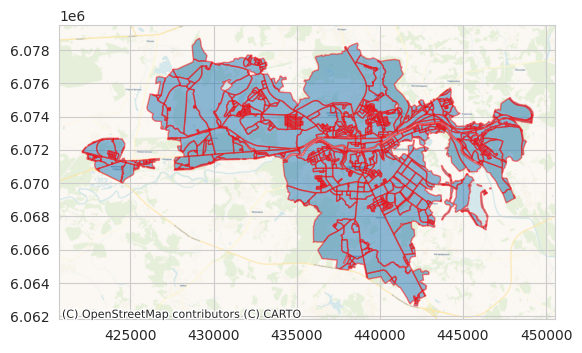

In [37]:
ax = blocks_filtered.plot(alpha=0.5, edgecolor=ec)
cx.add_basemap(ax, crs=blocks_filtered.crs, source=cx.providers.CartoDB.Voyager)

In [38]:
blocks_filtered.explore()

Output hidden; open in https://colab.research.google.com to view.